In [1]:
import mne
import os
import scipy.stats
import pickle
import argparse
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from src.utils import get_bids_file, compute_ch_adjacency
from src.params import BIDS_PATH, PREPROC_PATH, SUBJ_CLEAN, ACTIVE_RUN, RESULT_PATH, EVENTS_ID, FIG_PATH
from mne.stats import spatio_temporal_cluster_test, combine_adjacency, spatio_temporal_cluster_1samp_test
from mne.epochs import equalize_epoch_counts
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mne.viz import plot_compare_evokeds

In [2]:
task = 'LaughterPassive'
subj_list = SUBJ_CLEAN
stage = "epo"

# Select what conditions to compute (str)
cond1 = 'LaughReal'
cond2 = 'BaselineZero'
conditions = conditions = cond1 + '-' + cond2
condition_list = [cond1, cond2]
picks = "meg" # Select MEG channels

In [3]:
contrasts_all_subject = []
evoked_condition1 = []
evoked_condition2 = []

for subj in SUBJ_CLEAN :
    print("processing -->", subj)
    # TODO : change with AR_epochs
    _, path_epochs = get_bids_file(RESULT_PATH, task=task, subj=subj, stage="AR_epo")
    epochs = mne.read_epochs(path_epochs, verbose=None)
    epochs.apply_baseline(baseline=(None, 0))
    
    # Take nb channel and time
    baseline_data = np.zeros((epochs.get_data().shape[1], epochs.get_data().shape[2]))

    # Drop EEg channels and equalize event number
    evoked_condition1.append(epochs[cond1].average()) 
    baseline = mne.EvokedArray(baseline_data, epochs.info, tmin=-0.5, comment='baseline')

    contrast = mne.combine_evoked([epochs[cond1].average(), baseline], weights=[1, -1])
    contrast.pick_types(meg=True, ref_meg=False,  exclude='bads')
    contrasts_all_subject.append(contrast)

    
# Combine all subject together
evoked_contrast = mne.combine_evoked(evoked_condition1, 'equal')

# Compute adjacency by using compute_ch_adjacency function
# as we have 270 channels and not 275 as the CTF275 template provide
print('Computing adjacency.')
adjacency, ch_names = compute_ch_adjacency(evoked_contrast.info, ch_type='mag')
print(adjacency.shape)

# Obtain the data as a 3D matrix and transpose it such that
# the dimensions are as expected for the cluster permutation test:
# n_epochs × n_times × n_channels
X = np.array([c.data for c in contrasts_all_subject])
X = np.transpose(X, [0, 2, 1])
print(X.shape)

degrees_of_freedom = len(contrasts_all_subject) - 1
t_thresh = scipy.stats.t.ppf(1 - 0.001 / 2, df=degrees_of_freedom)

# Run the analysis
print('Clustering.')
cluster_stats = \
    spatio_temporal_cluster_1samp_test(X, n_permutations=1024,
                                threshold=t_thresh, tail=0,
                                adjacency=adjacency,
                                out_type='indices', verbose=None, 
                                step_down_p = 0.05, check_disjoint=True)

T_obs, clusters, cluster_p_values, H0 = cluster_stats

good_cluster_inds = np.where(cluster_p_values < 0.01)[0]
print("Good clusters: %s" % good_cluster_inds)

processing --> 01
Reading /home/claraelk/scratch/laughter_data/results/meg/reports/sub-01/sub-01_task-LaughterPassive_run-all_AR_epo.fif ...
    Found the data of interest:
        t =    -500.00 ...    1500.00 ms
        0 CTF compensation matrices available
Adding metadata with 9 columns
200 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
processing --> 02
Reading /home/claraelk/scratch/laughter_data/results/meg/reports/sub-02/sub-02_task-LaughterPassive_run-all_AR_epo.fif ...
    Found the data of interest:
        t =    -500.00 ...    1500.00 ms
        0 CTF compensation matrices available
Adding metadata with 9 columns
195 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
processing --> 03
Reading /home/claraelk/scratch/laughter_data/results/meg/reports/sub-03/sub-03_task-LaughterPassive_run-all_AR_epo.fif ...
    Found the data of

Adding metadata with 9 columns
199 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
processing --> 22
Reading /home/claraelk/scratch/laughter_data/results/meg/reports/sub-22/sub-22_task-LaughterPassive_run-all_AR_epo.fif ...
    Found the data of interest:
        t =    -500.00 ...    1500.00 ms
        0 CTF compensation matrices available
Adding metadata with 9 columns
200 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
processing --> 23
Reading /home/claraelk/scratch/laughter_data/results/meg/reports/sub-23/sub-23_task-LaughterPassive_run-all_AR_epo.fif ...
    Found the data of interest:
        t =    -500.00 ...    1500.00 ms
        0 CTF compensation matrices available
Adding metadata with 9 columns
190 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
pro

  0%|          | Permuting : 0/1023 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #1 found 8 clusters to exclude from subsequent iterations


  0%|          | Permuting : 0/1023 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #2 found 0 additional clusters to exclude from subsequent iterations
Good clusters: [ 22  49  71 143 165 171]


In [4]:
zscore = evoked_contrast.copy()
zscore.apply_function(lambda x : ((x - np.mean(x))/np.std(x)))

<Evoked | '0.037 × LaughReal + 0.037 × LaughReal + 0.037 × LaughReal + 0.037 × LaughReal + 0.037 × LaughReal + 0.037 × LaughReal + 0.037 × LaughReal + 0.037 × LaughReal + 0.037 × LaughReal + 0.037 × LaughReal + 0.037 × LaughReal + 0.037 × LaughReal + 0.037 × LaughReal + 0.037 × LaughReal + 0.037 × LaughReal + 0.037 × LaughReal + 0.037 × LaughReal + 0.037 × LaughReal + 0.037 × LaughReal + 0.037 × LaughReal + 0.037 × LaughReal + 0.037 × LaughReal + 0.037 × LaughReal + 0.037 × LaughReal + 0.037 × LaughReal + 0.037 × LaughReal + 0.037 × LaughReal' (average, N=1318.1754141536824), -0.5 – 1.5 sec, baseline -0.5 – 0 sec, 270 ch, ~6.0 MB>

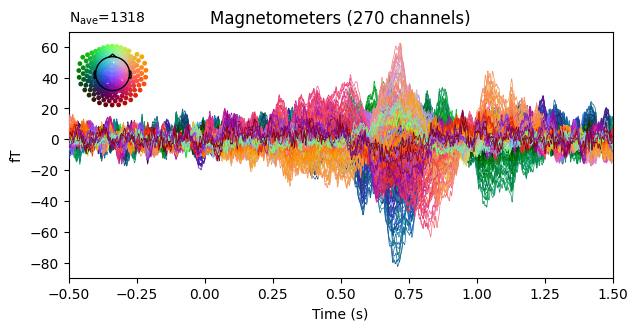

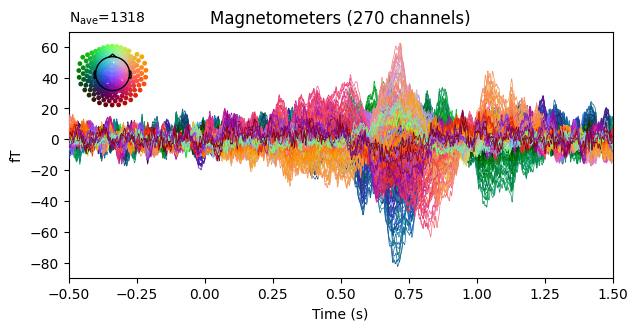

In [5]:
evoked_contrast.plot()

In [10]:
type(zscore)

mne.epochs.EpochsFIF

In [4]:
evoked_condition1 = []
evoked_condition2 = []
evoked_zscore = []

for subj in SUBJ_CLEAN :
    print("processing -->", subj)

    _, path_epochs = get_bids_file(RESULT_PATH, task=task, subj=subj, stage="AR_epo")
    epochs_AR = mne.read_epochs(path_epochs, verbose=None)
    epochs_AR.apply_baseline(baseline=(None, 0))
    epochs_AR.filter(1, 20)
    epochs_AR.resample(300)

    zscore = epochs_AR.copy()
    zscore.apply_function(lambda x : ((x - np.mean(x))/np.std(x)))

    # Drop EEg channels and equalize event number
    # Take nb channel and time
    baseline_data = np.zeros((epochs_AR.get_data().shape[1], epochs_AR.get_data().shape[2]))

    # Drop EEg channels and equalize event number
    evoked_zscore.append(zscore[cond1].average())

    evoked_condition1.append(epochs_AR[cond1].average()) 
    baseline = mne.EvokedArray(baseline_data, epochs.info, tmin=-0.5, comment='baseline')
    evoked_condition2.append(baseline)

# Prepare data for plotting
evokeds = {cond1 : evoked_condition1, cond2 : evoked_condition2}

processing --> 01
Reading /home/claraelk/scratch/laughter_data/results/meg/reports/sub-01/sub-01_task-LaughterPassive_run-all_AR_epo.fif ...
    Found the data of interest:
        t =    -500.00 ...    1500.00 ms
        0 CTF compensation matrices available
Adding metadata with 9 columns
200 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
Setting up band-pass filter from 1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 3961 samples (3.301 sec)



/tmp/ipykernel_1196128/1134484082.py:11: RuntimeWarning: filter_length (3961) is longer than the signal (2401), distortion is likely. Reduce filter length or filter a longer signal.
  epochs_AR.filter(1, 20)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 54000 out of 54000 | elapsed:  1.9min finished


processing --> 02
Reading /home/claraelk/scratch/laughter_data/results/meg/reports/sub-02/sub-02_task-LaughterPassive_run-all_AR_epo.fif ...
    Found the data of interest:
        t =    -500.00 ...    1500.00 ms
        0 CTF compensation matrices available
Adding metadata with 9 columns
195 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
Setting up band-pass filter from 1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 3961 samples (3.301 sec)



/tmp/ipykernel_1196128/1134484082.py:11: RuntimeWarning: filter_length (3961) is longer than the signal (2401), distortion is likely. Reduce filter length or filter a longer signal.
  epochs_AR.filter(1, 20)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 52650 out of 52650 | elapsed:  2.6min finished


processing --> 03
Reading /home/claraelk/scratch/laughter_data/results/meg/reports/sub-03/sub-03_task-LaughterPassive_run-all_AR_epo.fif ...
    Found the data of interest:
        t =    -500.00 ...    1500.00 ms
        0 CTF compensation matrices available
Adding metadata with 9 columns
200 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
Setting up band-pass filter from 1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 3961 samples (3.301 sec)



/tmp/ipykernel_1196128/1134484082.py:11: RuntimeWarning: filter_length (3961) is longer than the signal (2401), distortion is likely. Reduce filter length or filter a longer signal.
  epochs_AR.filter(1, 20)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 54000 out of 54000 | elapsed:  1.7min finished


processing --> 04
Reading /home/claraelk/scratch/laughter_data/results/meg/reports/sub-04/sub-04_task-LaughterPassive_run-all_AR_epo.fif ...
    Found the data of interest:
        t =    -500.00 ...    1500.00 ms
        0 CTF compensation matrices available
Adding metadata with 9 columns
192 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
Setting up band-pass filter from 1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 3961 samples (3.301 sec)



/tmp/ipykernel_1196128/1134484082.py:11: RuntimeWarning: filter_length (3961) is longer than the signal (2401), distortion is likely. Reduce filter length or filter a longer signal.
  epochs_AR.filter(1, 20)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 51840 out of 51840 | elapsed:  2.5min finished


processing --> 05
Reading /home/claraelk/scratch/laughter_data/results/meg/reports/sub-05/sub-05_task-LaughterPassive_run-all_AR_epo.fif ...
    Found the data of interest:
        t =    -500.00 ...    1500.00 ms
        0 CTF compensation matrices available
Adding metadata with 9 columns
200 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
Setting up band-pass filter from 1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 3961 samples (3.301 sec)



/tmp/ipykernel_1196128/1134484082.py:11: RuntimeWarning: filter_length (3961) is longer than the signal (2401), distortion is likely. Reduce filter length or filter a longer signal.
  epochs_AR.filter(1, 20)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 54000 out of 54000 | elapsed:  2.6min finished


processing --> 06
Reading /home/claraelk/scratch/laughter_data/results/meg/reports/sub-06/sub-06_task-LaughterPassive_run-all_AR_epo.fif ...
    Found the data of interest:
        t =    -500.00 ...    1500.00 ms
        0 CTF compensation matrices available
Adding metadata with 9 columns
200 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
Setting up band-pass filter from 1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 3961 samples (3.301 sec)



/tmp/ipykernel_1196128/1134484082.py:11: RuntimeWarning: filter_length (3961) is longer than the signal (2401), distortion is likely. Reduce filter length or filter a longer signal.
  epochs_AR.filter(1, 20)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 54000 out of 54000 | elapsed:  1.6min finished


processing --> 07
Reading /home/claraelk/scratch/laughter_data/results/meg/reports/sub-07/sub-07_task-LaughterPassive_run-all_AR_epo.fif ...
    Found the data of interest:
        t =    -500.00 ...    1500.00 ms
        0 CTF compensation matrices available
Adding metadata with 9 columns
198 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
Setting up band-pass filter from 1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 3961 samples (3.301 sec)



/tmp/ipykernel_1196128/1134484082.py:11: RuntimeWarning: filter_length (3961) is longer than the signal (2401), distortion is likely. Reduce filter length or filter a longer signal.
  epochs_AR.filter(1, 20)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 53460 out of 53460 | elapsed:  2.3min finished


processing --> 08
Reading /home/claraelk/scratch/laughter_data/results/meg/reports/sub-08/sub-08_task-LaughterPassive_run-all_AR_epo.fif ...
    Found the data of interest:
        t =    -500.00 ...    1500.00 ms
        0 CTF compensation matrices available
Adding metadata with 9 columns
197 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
Setting up band-pass filter from 1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 3961 samples (3.301 sec)



/tmp/ipykernel_1196128/1134484082.py:11: RuntimeWarning: filter_length (3961) is longer than the signal (2401), distortion is likely. Reduce filter length or filter a longer signal.
  epochs_AR.filter(1, 20)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 53190 out of 53190 | elapsed:   31.0s finished


processing --> 09
Reading /home/claraelk/scratch/laughter_data/results/meg/reports/sub-09/sub-09_task-LaughterPassive_run-all_AR_epo.fif ...
    Found the data of interest:
        t =    -500.00 ...    1500.00 ms
        0 CTF compensation matrices available
Adding metadata with 9 columns
200 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
Setting up band-pass filter from 1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 3961 samples (3.301 sec)



/tmp/ipykernel_1196128/1134484082.py:11: RuntimeWarning: filter_length (3961) is longer than the signal (2401), distortion is likely. Reduce filter length or filter a longer signal.
  epochs_AR.filter(1, 20)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 54000 out of 54000 | elapsed:   51.0s finished


processing --> 10
Reading /home/claraelk/scratch/laughter_data/results/meg/reports/sub-10/sub-10_task-LaughterPassive_run-all_AR_epo.fif ...
    Found the data of interest:
        t =    -500.00 ...    1500.00 ms
        0 CTF compensation matrices available
Adding metadata with 9 columns
199 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
Setting up band-pass filter from 1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 3961 samples (3.301 sec)



/tmp/ipykernel_1196128/1134484082.py:11: RuntimeWarning: filter_length (3961) is longer than the signal (2401), distortion is likely. Reduce filter length or filter a longer signal.
  epochs_AR.filter(1, 20)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 53730 out of 53730 | elapsed:  1.9min finished


processing --> 11
Reading /home/claraelk/scratch/laughter_data/results/meg/reports/sub-11/sub-11_task-LaughterPassive_run-all_AR_epo.fif ...
    Found the data of interest:
        t =    -500.00 ...    1500.00 ms
        0 CTF compensation matrices available
Adding metadata with 9 columns
154 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
Setting up band-pass filter from 1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 3961 samples (3.301 sec)



/tmp/ipykernel_1196128/1134484082.py:11: RuntimeWarning: filter_length (3961) is longer than the signal (2401), distortion is likely. Reduce filter length or filter a longer signal.
  epochs_AR.filter(1, 20)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 41580 out of 41580 | elapsed:  1.0min finished


processing --> 12
Reading /home/claraelk/scratch/laughter_data/results/meg/reports/sub-12/sub-12_task-LaughterPassive_run-all_AR_epo.fif ...
    Found the data of interest:
        t =    -500.00 ...    1500.00 ms
        0 CTF compensation matrices available
Adding metadata with 9 columns
192 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
Setting up band-pass filter from 1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 3961 samples (3.301 sec)



/tmp/ipykernel_1196128/1134484082.py:11: RuntimeWarning: filter_length (3961) is longer than the signal (2401), distortion is likely. Reduce filter length or filter a longer signal.
  epochs_AR.filter(1, 20)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 51840 out of 51840 | elapsed:  2.6min finished


processing --> 13
Reading /home/claraelk/scratch/laughter_data/results/meg/reports/sub-13/sub-13_task-LaughterPassive_run-all_AR_epo.fif ...
    Found the data of interest:
        t =    -500.00 ...    1500.00 ms
        0 CTF compensation matrices available
Adding metadata with 9 columns
199 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
Setting up band-pass filter from 1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 3961 samples (3.301 sec)



/tmp/ipykernel_1196128/1134484082.py:11: RuntimeWarning: filter_length (3961) is longer than the signal (2401), distortion is likely. Reduce filter length or filter a longer signal.
  epochs_AR.filter(1, 20)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 53730 out of 53730 | elapsed:  1.6min finished


processing --> 14
Reading /home/claraelk/scratch/laughter_data/results/meg/reports/sub-14/sub-14_task-LaughterPassive_run-all_AR_epo.fif ...
    Found the data of interest:
        t =    -500.00 ...    1500.00 ms
        0 CTF compensation matrices available
Adding metadata with 9 columns
196 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
Setting up band-pass filter from 1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 3961 samples (3.301 sec)



/tmp/ipykernel_1196128/1134484082.py:11: RuntimeWarning: filter_length (3961) is longer than the signal (2401), distortion is likely. Reduce filter length or filter a longer signal.
  epochs_AR.filter(1, 20)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 52920 out of 52920 | elapsed:  1.7min finished


processing --> 15
Reading /home/claraelk/scratch/laughter_data/results/meg/reports/sub-15/sub-15_task-LaughterPassive_run-all_AR_epo.fif ...
    Found the data of interest:
        t =    -500.00 ...    1500.00 ms
        0 CTF compensation matrices available
Adding metadata with 9 columns
200 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
Setting up band-pass filter from 1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 3961 samples (3.301 sec)



/tmp/ipykernel_1196128/1134484082.py:11: RuntimeWarning: filter_length (3961) is longer than the signal (2401), distortion is likely. Reduce filter length or filter a longer signal.
  epochs_AR.filter(1, 20)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 54000 out of 54000 | elapsed:   30.4s finished


processing --> 16
Reading /home/claraelk/scratch/laughter_data/results/meg/reports/sub-16/sub-16_task-LaughterPassive_run-all_AR_epo.fif ...
    Found the data of interest:
        t =    -500.00 ...    1500.00 ms
        0 CTF compensation matrices available
Adding metadata with 9 columns
194 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
Setting up band-pass filter from 1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 3961 samples (3.301 sec)



/tmp/ipykernel_1196128/1134484082.py:11: RuntimeWarning: filter_length (3961) is longer than the signal (2401), distortion is likely. Reduce filter length or filter a longer signal.
  epochs_AR.filter(1, 20)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 52380 out of 52380 | elapsed:  1.5min finished


processing --> 18
Reading /home/claraelk/scratch/laughter_data/results/meg/reports/sub-18/sub-18_task-LaughterPassive_run-all_AR_epo.fif ...
    Found the data of interest:
        t =    -500.00 ...    1500.00 ms
        0 CTF compensation matrices available
Adding metadata with 9 columns
185 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
Setting up band-pass filter from 1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 3961 samples (3.301 sec)



/tmp/ipykernel_1196128/1134484082.py:11: RuntimeWarning: filter_length (3961) is longer than the signal (2401), distortion is likely. Reduce filter length or filter a longer signal.
  epochs_AR.filter(1, 20)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 49950 out of 49950 | elapsed:  2.2min finished


processing --> 19
Reading /home/claraelk/scratch/laughter_data/results/meg/reports/sub-19/sub-19_task-LaughterPassive_run-all_AR_epo.fif ...
    Found the data of interest:
        t =    -500.00 ...    1500.00 ms
        0 CTF compensation matrices available
Adding metadata with 9 columns
199 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
Setting up band-pass filter from 1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 3961 samples (3.301 sec)



/tmp/ipykernel_1196128/1134484082.py:11: RuntimeWarning: filter_length (3961) is longer than the signal (2401), distortion is likely. Reduce filter length or filter a longer signal.
  epochs_AR.filter(1, 20)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 53730 out of 53730 | elapsed:  2.3min finished


processing --> 20
Reading /home/claraelk/scratch/laughter_data/results/meg/reports/sub-20/sub-20_task-LaughterPassive_run-all_AR_epo.fif ...
    Found the data of interest:
        t =    -500.00 ...    1500.00 ms
        0 CTF compensation matrices available
Adding metadata with 9 columns
192 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
Setting up band-pass filter from 1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 3961 samples (3.301 sec)



/tmp/ipykernel_1196128/1134484082.py:11: RuntimeWarning: filter_length (3961) is longer than the signal (2401), distortion is likely. Reduce filter length or filter a longer signal.
  epochs_AR.filter(1, 20)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 51840 out of 51840 | elapsed:  1.5min finished


processing --> 21
Reading /home/claraelk/scratch/laughter_data/results/meg/reports/sub-21/sub-21_task-LaughterPassive_run-all_AR_epo.fif ...
    Found the data of interest:
        t =    -500.00 ...    1500.00 ms
        0 CTF compensation matrices available
Adding metadata with 9 columns
199 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
Setting up band-pass filter from 1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 3961 samples (3.301 sec)



/tmp/ipykernel_1196128/1134484082.py:11: RuntimeWarning: filter_length (3961) is longer than the signal (2401), distortion is likely. Reduce filter length or filter a longer signal.
  epochs_AR.filter(1, 20)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 53730 out of 53730 | elapsed:  2.1min finished


processing --> 22
Reading /home/claraelk/scratch/laughter_data/results/meg/reports/sub-22/sub-22_task-LaughterPassive_run-all_AR_epo.fif ...
    Found the data of interest:
        t =    -500.00 ...    1500.00 ms
        0 CTF compensation matrices available
Adding metadata with 9 columns
200 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
Setting up band-pass filter from 1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 3961 samples (3.301 sec)



/tmp/ipykernel_1196128/1134484082.py:11: RuntimeWarning: filter_length (3961) is longer than the signal (2401), distortion is likely. Reduce filter length or filter a longer signal.
  epochs_AR.filter(1, 20)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 54000 out of 54000 | elapsed:  2.7min finished


processing --> 23
Reading /home/claraelk/scratch/laughter_data/results/meg/reports/sub-23/sub-23_task-LaughterPassive_run-all_AR_epo.fif ...
    Found the data of interest:
        t =    -500.00 ...    1500.00 ms
        0 CTF compensation matrices available
Adding metadata with 9 columns
190 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
Setting up band-pass filter from 1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 3961 samples (3.301 sec)



/tmp/ipykernel_1196128/1134484082.py:11: RuntimeWarning: filter_length (3961) is longer than the signal (2401), distortion is likely. Reduce filter length or filter a longer signal.
  epochs_AR.filter(1, 20)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 51300 out of 51300 | elapsed:  1.8min finished


processing --> 24
Reading /home/claraelk/scratch/laughter_data/results/meg/reports/sub-24/sub-24_task-LaughterPassive_run-all_AR_epo.fif ...
    Found the data of interest:
        t =    -500.00 ...    1500.00 ms
        0 CTF compensation matrices available
Adding metadata with 9 columns
197 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
Setting up band-pass filter from 1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 3961 samples (3.301 sec)



/tmp/ipykernel_1196128/1134484082.py:11: RuntimeWarning: filter_length (3961) is longer than the signal (2401), distortion is likely. Reduce filter length or filter a longer signal.
  epochs_AR.filter(1, 20)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 53190 out of 53190 | elapsed:  1.5min finished


processing --> 25
Reading /home/claraelk/scratch/laughter_data/results/meg/reports/sub-25/sub-25_task-LaughterPassive_run-all_AR_epo.fif ...
    Found the data of interest:
        t =    -500.00 ...    1500.00 ms
        0 CTF compensation matrices available
Adding metadata with 9 columns
199 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
Setting up band-pass filter from 1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 3961 samples (3.301 sec)



/tmp/ipykernel_1196128/1134484082.py:11: RuntimeWarning: filter_length (3961) is longer than the signal (2401), distortion is likely. Reduce filter length or filter a longer signal.
  epochs_AR.filter(1, 20)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 53730 out of 53730 | elapsed:  1.6min finished


processing --> 28
Reading /home/claraelk/scratch/laughter_data/results/meg/reports/sub-28/sub-28_task-LaughterPassive_run-all_AR_epo.fif ...
    Found the data of interest:
        t =    -500.00 ...    1500.00 ms
        0 CTF compensation matrices available
Adding metadata with 9 columns
200 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
Setting up band-pass filter from 1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 3961 samples (3.301 sec)



/tmp/ipykernel_1196128/1134484082.py:11: RuntimeWarning: filter_length (3961) is longer than the signal (2401), distortion is likely. Reduce filter length or filter a longer signal.
  epochs_AR.filter(1, 20)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 54000 out of 54000 | elapsed:   32.1s finished


processing --> 30
Reading /home/claraelk/scratch/laughter_data/results/meg/reports/sub-30/sub-30_task-LaughterPassive_run-all_AR_epo.fif ...
    Found the data of interest:
        t =    -500.00 ...    1500.00 ms
        0 CTF compensation matrices available
Adding metadata with 9 columns
200 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
Setting up band-pass filter from 1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 3961 samples (3.301 sec)



/tmp/ipykernel_1196128/1134484082.py:11: RuntimeWarning: filter_length (3961) is longer than the signal (2401), distortion is likely. Reduce filter length or filter a longer signal.
  epochs_AR.filter(1, 20)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 54000 out of 54000 | elapsed:   31.4s finished


processing --> 32
Reading /home/claraelk/scratch/laughter_data/results/meg/reports/sub-32/sub-32_task-LaughterPassive_run-all_AR_epo.fif ...
    Found the data of interest:
        t =    -500.00 ...    1500.00 ms
        0 CTF compensation matrices available
Adding metadata with 9 columns
197 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
Setting up band-pass filter from 1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 3961 samples (3.301 sec)



/tmp/ipykernel_1196128/1134484082.py:11: RuntimeWarning: filter_length (3961) is longer than the signal (2401), distortion is likely. Reduce filter length or filter a longer signal.
  epochs_AR.filter(1, 20)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 53190 out of 53190 | elapsed:   29.9s finished


In [4]:
task = 'LaughterActive'

# Select what conditions to compute (str)
cond1 = 'LaughReal'
cond2 = 'BaselineZero'
conditions = conditions = cond1 + '-' + cond2
condition_list = [cond1, cond2]

conditions = cond1 + "-" + cond2

_, save_contrasts = get_bids_file(RESULT_PATH, stage = "erp-contrast", task=task, condition = conditions)

_, save_cluster_stats = get_bids_file(RESULT_PATH, stage = "erp-clusters", task=task, measure="Ttest-clusters", condition = conditions)

#with open(save_contrasts, 'wb') as f:
#    pickle.dump(contrast, f)  

#with open(save_cluster_stats, 'wb') as f:
#    pickle.dump(cluster_stats, f)

EOFError: Ran out of input

combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"


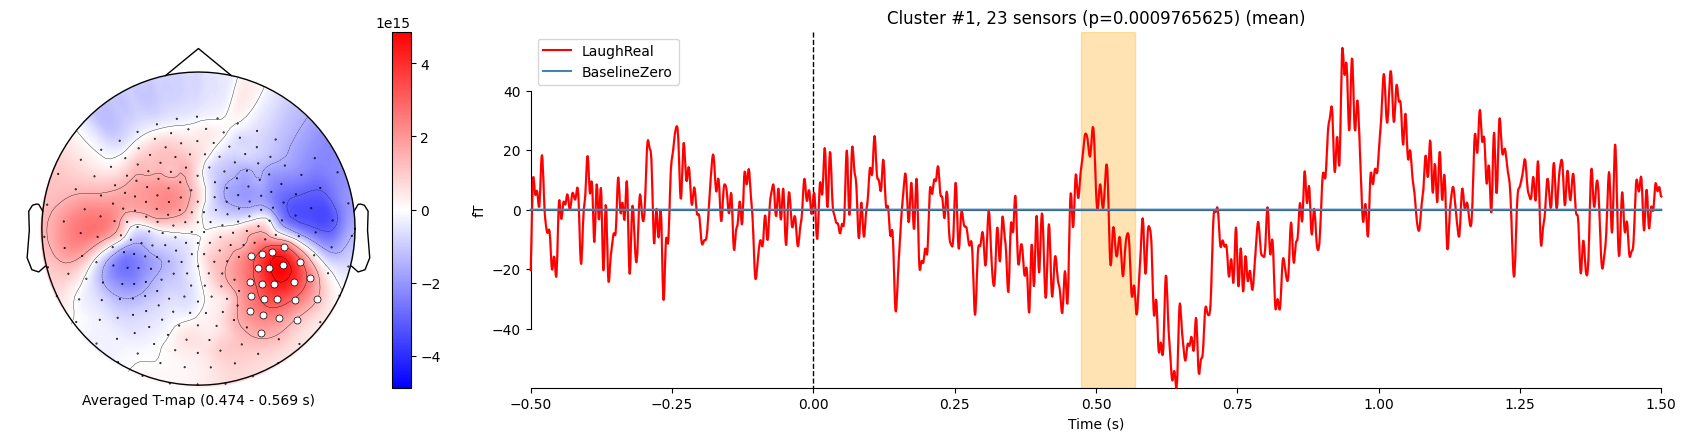

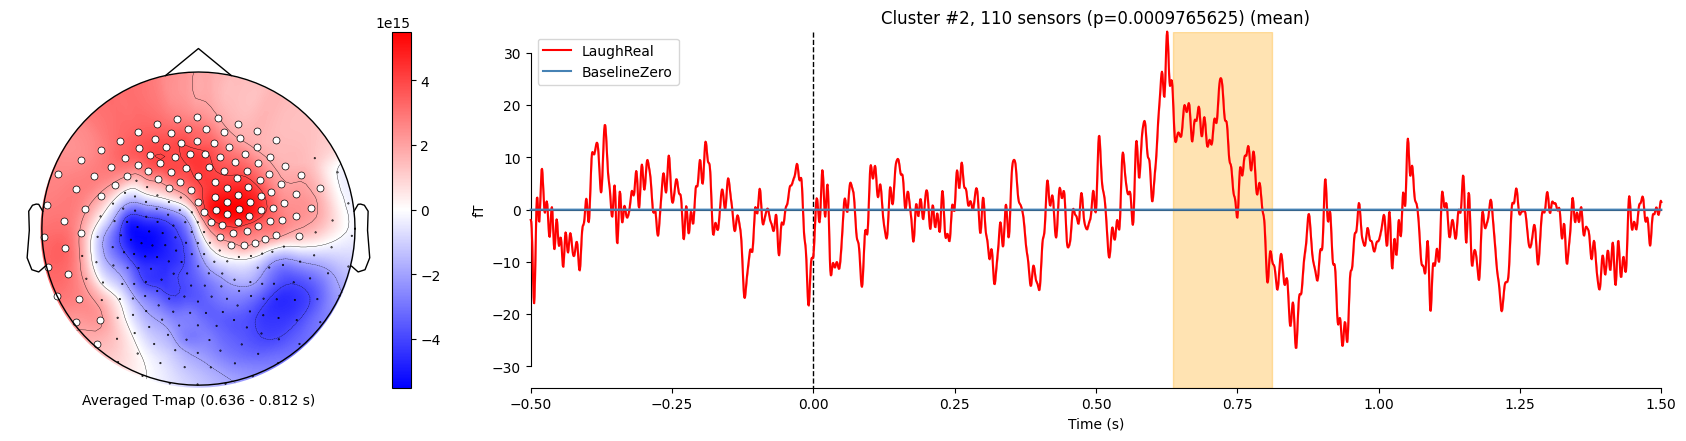

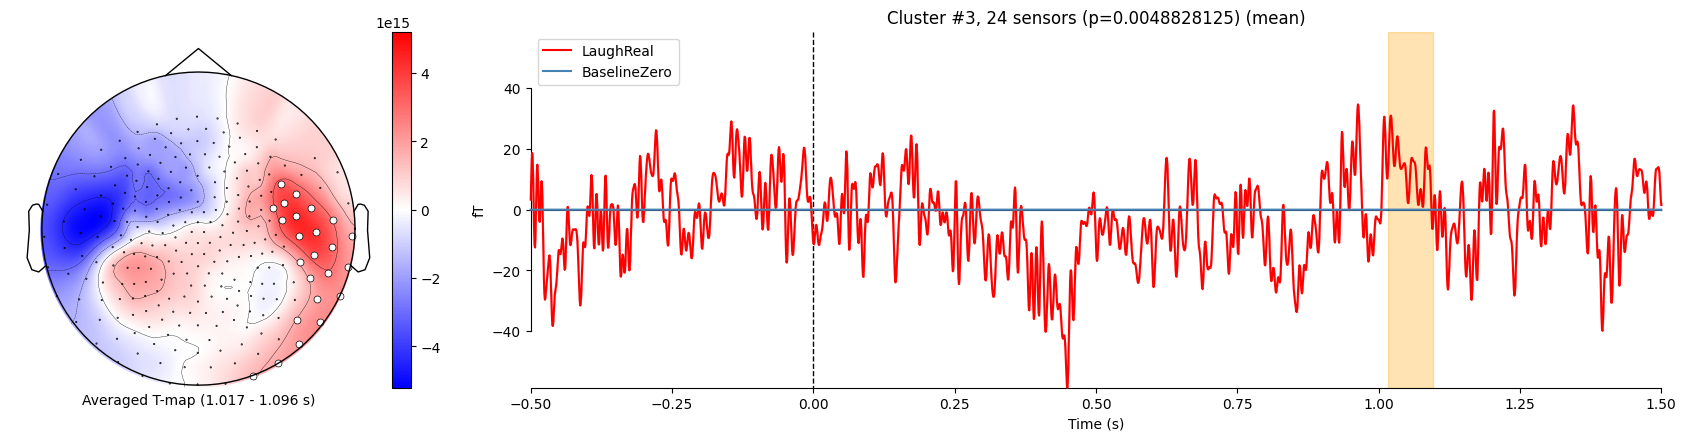

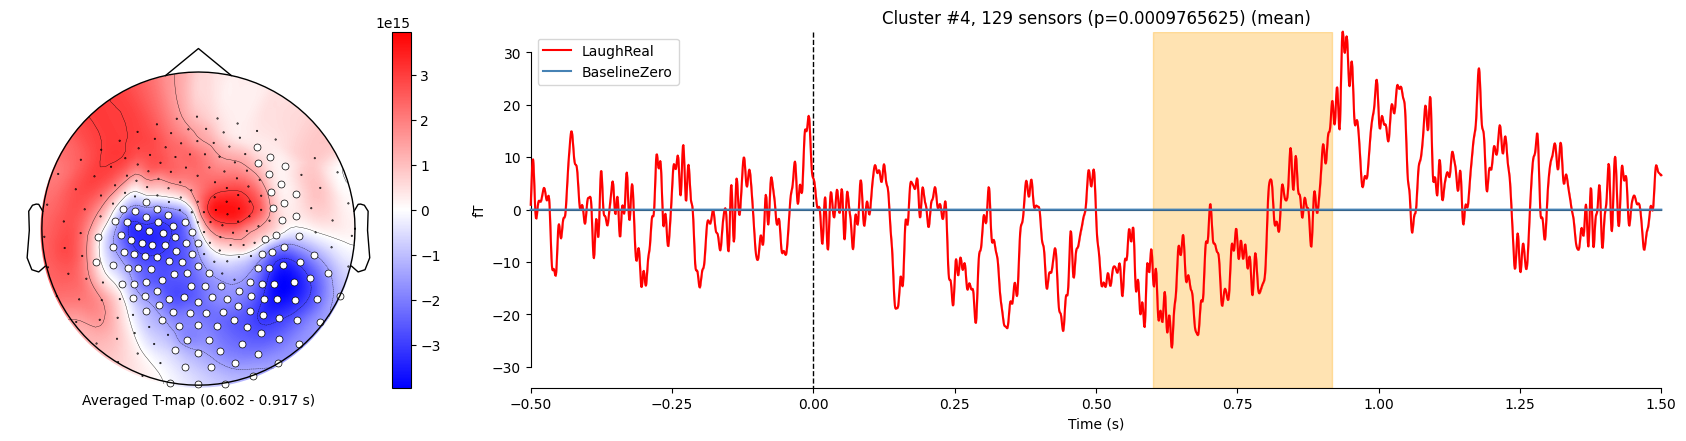

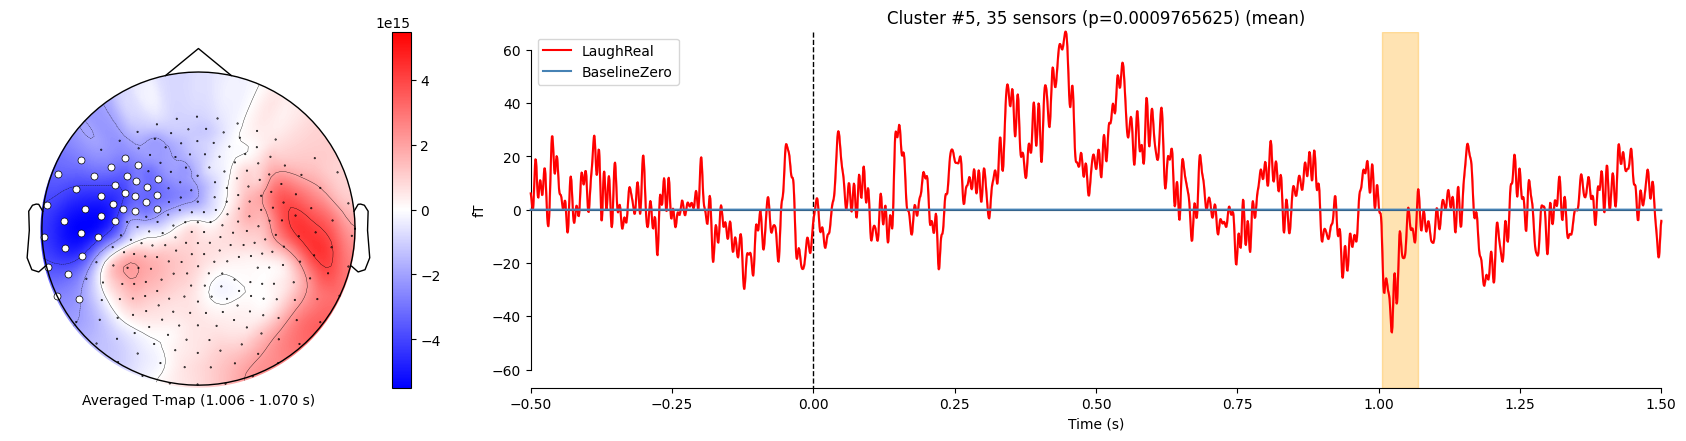

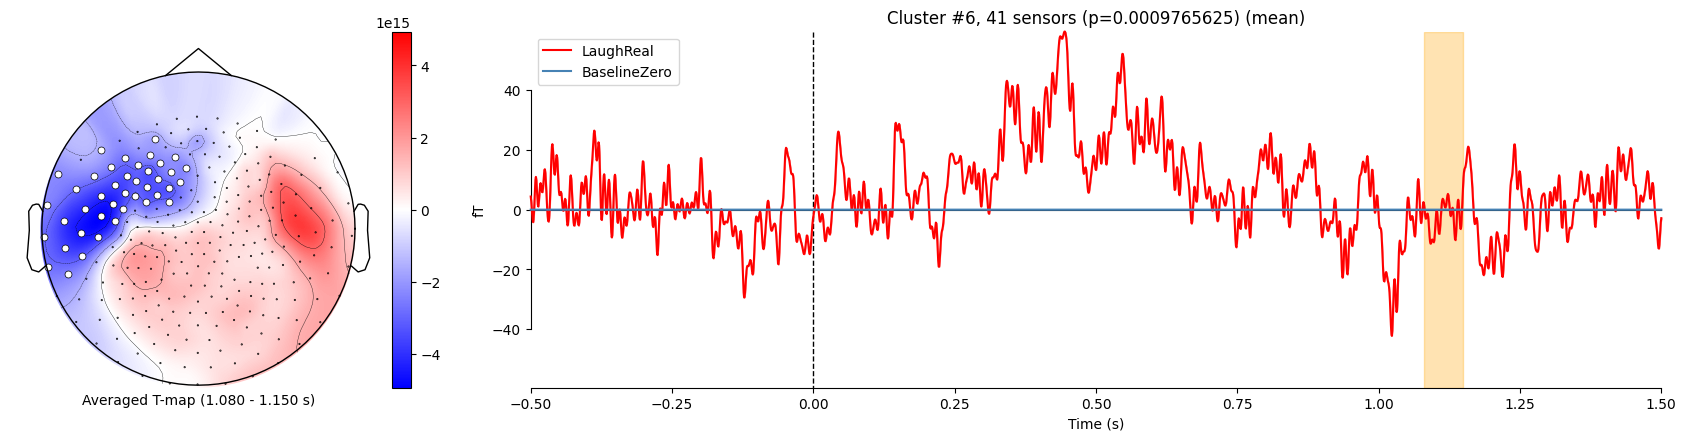

In [5]:
T_obs, clusters, p_values, _ = cluster_stats

p_accept = 0.01
good_cluster_inds = np.where(p_values < p_accept)[0]

# configure variables for visualization
colors = "r",'steelblue'
linestyles = '-', '--'

times = contrast.times * 1e3

# loop over clusters
for i_clu, clu_idx in enumerate(good_cluster_inds):

    # unpack cluster information, get unique indices
    time_inds, space_inds = np.squeeze(clusters[clu_idx])
    ch_inds = np.unique(space_inds)
    time_inds = np.unique(time_inds)


    sig_times = contrast.times[time_inds]

    # get topography for F stat
    t_map = T_obs[time_inds, ...].mean(axis=0)

    # get signals at the sensors contributing to the cluster
    sig_times = contrast.times[time_inds]

    # create spatial mask
    mask = np.zeros((t_map.shape[0], 1), dtype=bool)
    mask[ch_inds, :] = True

    # initialize figure
    fig, ax_topo = plt.subplots(1, 1, figsize=(17, 5))

    # plot average test statistic and mark significant sensors
    t_evoked = mne.EvokedArray(t_map[:, np.newaxis], contrast.info, tmin=0)

    t_evoked.plot_topomap(times=0, mask=mask, axes=ax_topo, cmap='bwr',
                        cnorm = matplotlib.colors.CenteredNorm(vcenter=0), show=False,
                        colorbar=False, mask_params=dict(markersize=10), extrapolate='head',
                        sphere=(0, 0.01, 0, 0.184))

    image = ax_topo.images[0]

    # remove the title that would otherwise say "0.000 s"
    ax_topo.set_title("")

    # create additional axes (for ERF and colorbar)
    divider = make_axes_locatable(ax_topo)

    # add axes for colorbar
    ax_colorbar = divider.append_axes('right', size='5%', pad=0.05)
    plt.colorbar(image, cax=ax_colorbar)
    ax_topo.set_xlabel(
        'Averaged T-map ({:0.3f} - {:0.3f} s)'.format(*sig_times[[0, -1]]))

    # add new axis for time courses and plot time courses
    ax_signals = divider.append_axes('right', size='300%', pad=1.2)

    # TODO add color for noise around signal
    title = 'Cluster #{0}, {1} sensors (p={2})'.format(i_clu + 1, len(ch_inds), p_values[clu_idx])

    plot_compare_evokeds(evokeds, title=title, picks=ch_inds, axes=ax_signals,
                    colors=colors, show=False,
                    split_legend=True, truncate_yaxis='auto', combine="mean")

    # plot temporal cluster extent
    ymin, ymax = ax_signals.get_ylim()
    ax_signals.fill_betweenx((ymin, ymax), sig_times[0], sig_times[-1],
                        color='orange', alpha=0.3)
    # clean up viz
    mne.viz.tight_layout(fig=fig)
    fig.subplots_adjust(bottom=.05)
    
    #plt.savefig(FIG_PATH + 'clusters-erp/sub-all_run-all_task-{}_cond-{}_meas-Ttest-cluster_erp{}.png'.format(task, conditions, i_clu))

Z-SCORE

In [13]:
evokeds = {cond1 : evoked_zscore, cond2 : evoked_condition2}

combining channels using "gfp"
combining channels using "gfp"
combining channels using "gfp"
combining channels using "gfp"
combining channels using "gfp"
combining channels using "gfp"
combining channels using "gfp"
combining channels using "gfp"
combining channels using "gfp"
combining channels using "gfp"
combining channels using "gfp"
combining channels using "gfp"
combining channels using "gfp"
combining channels using "gfp"


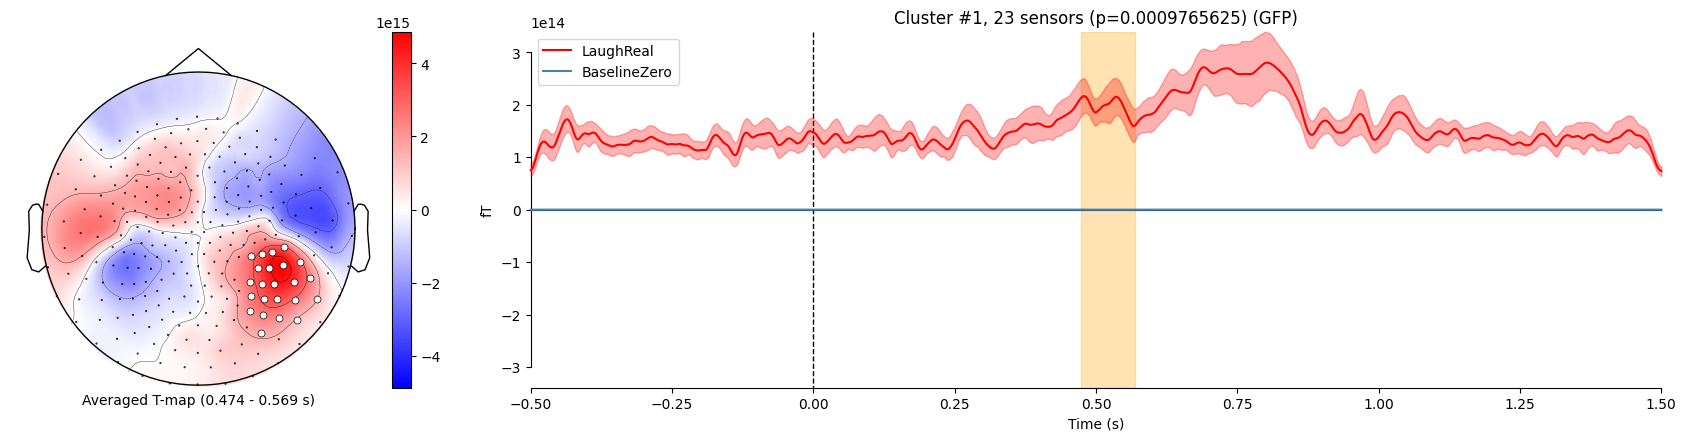

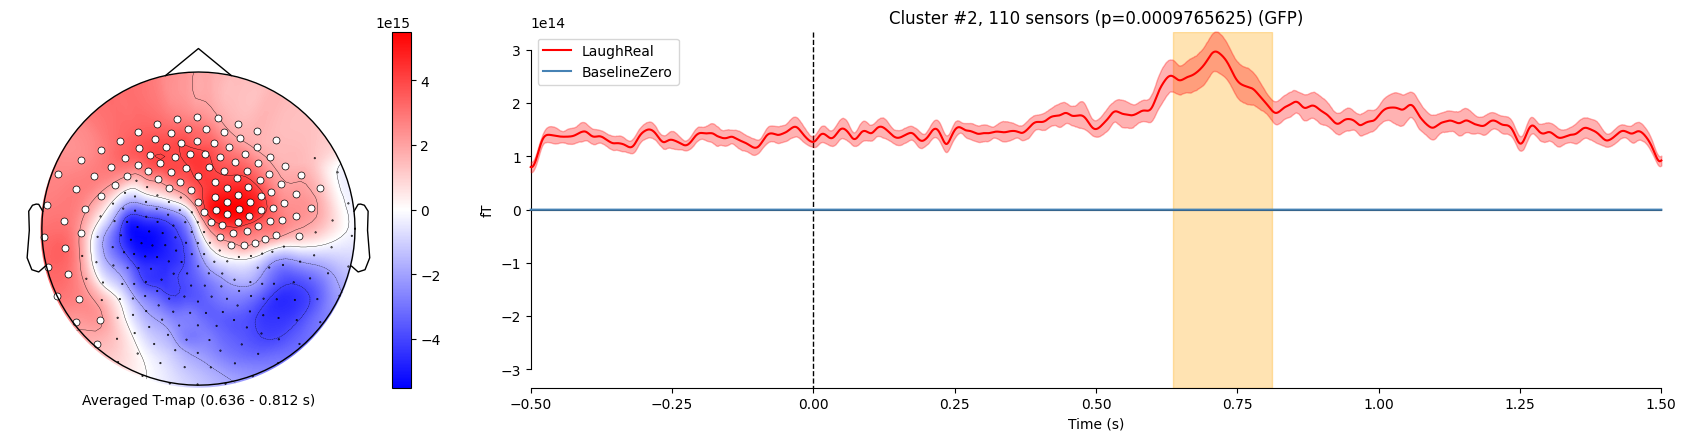

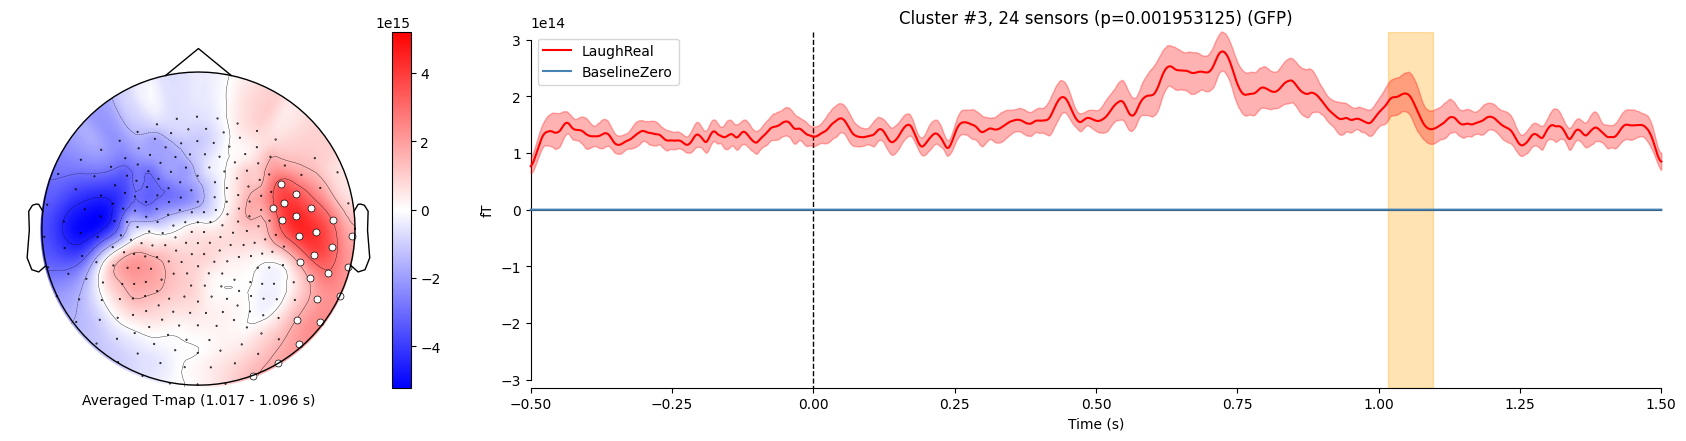

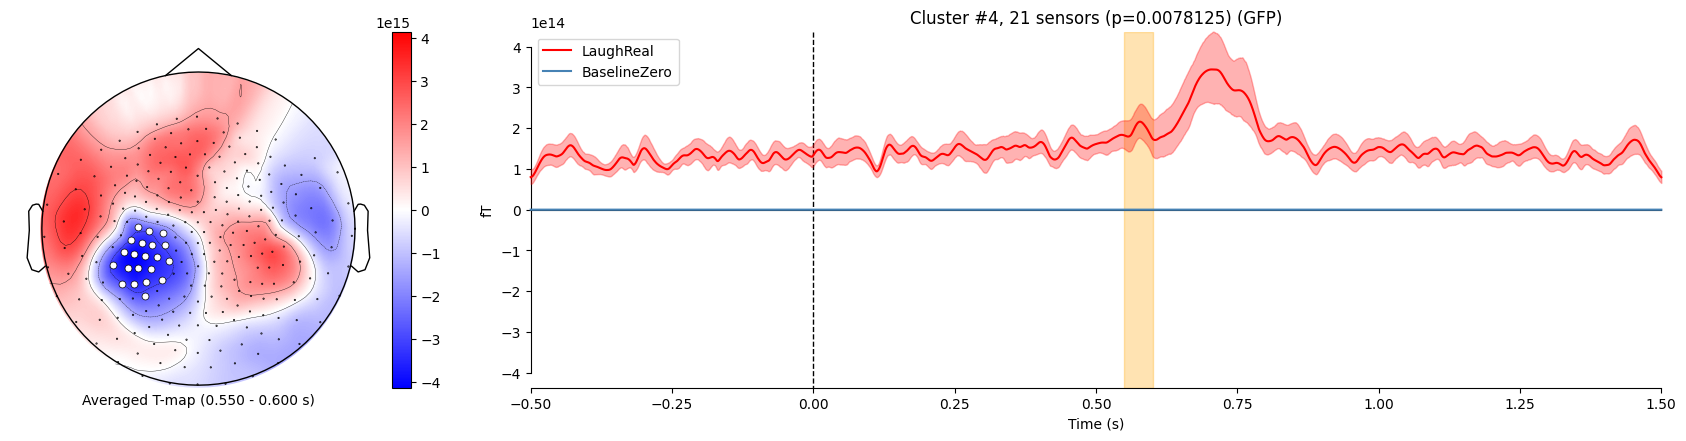

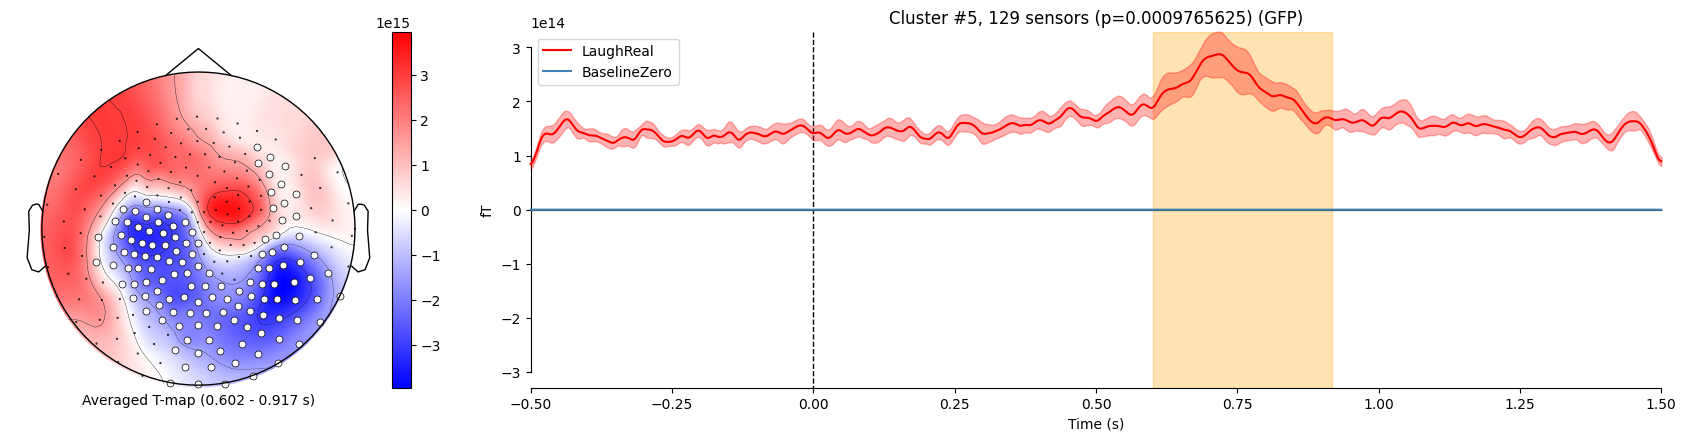

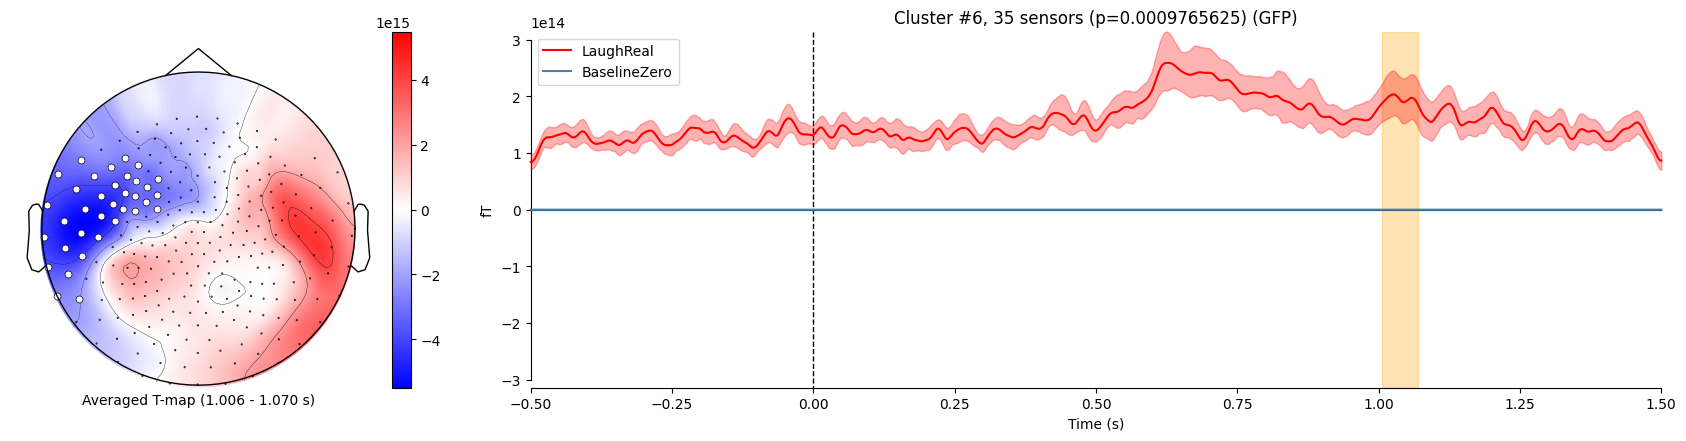

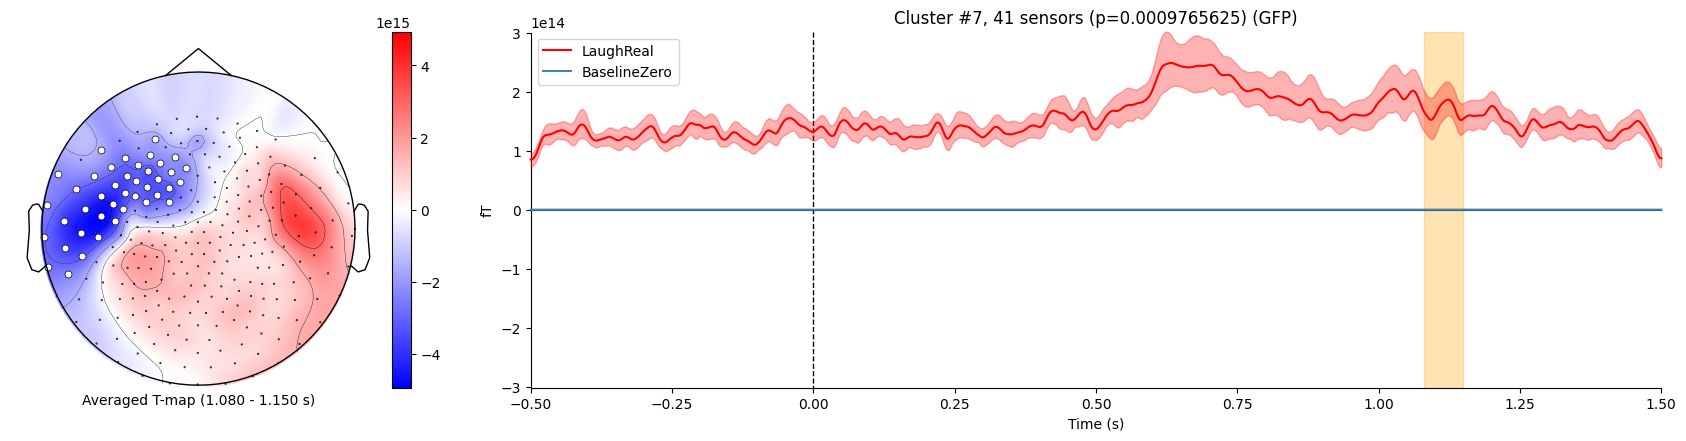

In [14]:
T_obs, clusters, p_values, _ = cluster_stats

p_accept = 0.01
good_cluster_inds = np.where(p_values < p_accept)[0]

# configure variables for visualization
colors = "r",'steelblue'
linestyles = '-', '--'

times = contrast.times * 1e3

# loop over clusters
for i_clu, clu_idx in enumerate(good_cluster_inds):

    # unpack cluster information, get unique indices
    time_inds, space_inds = np.squeeze(clusters[clu_idx])
    ch_inds = np.unique(space_inds)
    time_inds = np.unique(time_inds)


    sig_times = contrast.times[time_inds]

    # get topography for F stat
    t_map = T_obs[time_inds, ...].mean(axis=0)

    # get signals at the sensors contributing to the cluster
    sig_times = contrast.times[time_inds]

    # create spatial mask
    mask = np.zeros((t_map.shape[0], 1), dtype=bool)
    mask[ch_inds, :] = True

    # initialize figure
    fig, ax_topo = plt.subplots(1, 1, figsize=(17, 5))

    # plot average test statistic and mark significant sensors
    t_evoked = mne.EvokedArray(t_map[:, np.newaxis], contrast.info, tmin=0)

    t_evoked.plot_topomap(times=0, mask=mask, axes=ax_topo, cmap='bwr',
                        cnorm = matplotlib.colors.CenteredNorm(vcenter=0), show=False,
                        colorbar=False, mask_params=dict(markersize=10), extrapolate='head',
                        sphere=(0, 0.01, 0, 0.184))

    image = ax_topo.images[0]

    # remove the title that would otherwise say "0.000 s"
    ax_topo.set_title("")

    # create additional axes (for ERF and colorbar)
    divider = make_axes_locatable(ax_topo)

    # add axes for colorbar
    ax_colorbar = divider.append_axes('right', size='5%', pad=0.05)
    plt.colorbar(image, cax=ax_colorbar)
    ax_topo.set_xlabel(
        'Averaged T-map ({:0.3f} - {:0.3f} s)'.format(*sig_times[[0, -1]]))

    # add new axis for time courses and plot time courses
    ax_signals = divider.append_axes('right', size='300%', pad=1.2)

    # TODO add color for noise around signal
    title = 'Cluster #{0}, {1} sensors (p={2})'.format(i_clu + 1, len(ch_inds), p_values[clu_idx])

    plot_compare_evokeds(evokeds, title=title, picks=ch_inds, axes=ax_signals,
                    colors=colors, show=False,
                    split_legend=True, truncate_yaxis='auto')

    # plot temporal cluster extent
    ymin, ymax = ax_signals.get_ylim()
    ax_signals.fill_betweenx((ymin, ymax), sig_times[0], sig_times[-1],
                        color='orange', alpha=0.3)
    # clean up viz
    mne.viz.tight_layout(fig=fig)
    fig.subplots_adjust(bottom=.05)
    
    #plt.savefig(FIG_PATH + 'clusters-erp/sub-all_run-all_task-{}_cond-{}_meas-Ttest-cluster_erp{}.png'.format(task, conditions, i_clu))